# 1) Setup

In [2]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import math
import scipy as sp
from scipy import stats

from copy import copy
import time
import yaml
import networkx as nx

import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

import pymongo
from pymongo import MongoClient
from datetime import datetime
from datetime import timedelta
print("done")

done


In [3]:
#import functions from python files

#1) data import & filtering
from get_data import *
from filter_data1 import *
from filter_data2 import *        #counts n_robots on an edge
from filter_data3 import *
from filter_data4 import *        #alternative to filter_data2
from select_data import *
from select_data_edge import *

#2) Bayesian: lognormal
from Gamma import *
from Lognormal import *

from Gaussian import *
from Gaussian_broadcast import *

from Normal_Gamma import *
from Normal_Gamma_bayes import *
from Normal_Gamma_bayes_update import *

from Gaussian_ml import *              # for comparison

#3) Measures of error
from integrate_pdf import *
from integrate import *
from integrate_trapezium import *
from integrate_simpson import *

from error_crps import *
from error_crps_single import *

#4) Clustering edges
from underscore_prefix import *
from underscore_suffix import *

from ks_between_edges import *
from get_context import *
from augment_with_context import *

from distances_ks import *
from distances_length import *
from distances_connections import *

from draw_graph import *
from draw_clusters import *

#5) Check
from draw_count import *

#6) Effect of increased congestion
from get_adjacent import *

print("done")

done


In [4]:
# load from excel (see FILTER.ipynb)
df = pd.read_excel("filtered_data_random.xlsx")
df = df.loc[:,["origin", "target", "edge_id", "operation_time"]]
    
print("done")

done


# 2) Fit data

In [4]:
# Select data of interest
wp1 = "WayPoint68"
wp2 = "WayPoint61"
edge = wp1 + "_" + wp2
subset = select_data_edge(df, edge)
#independent variable to plot over
t_op = subset["operation_time"]

print("done")

done


Time taken: 0.8524494171142578 secs
MAP mean: 0.252     MAP var: 0.159
Time for calculation: 11.395199298858643 secs


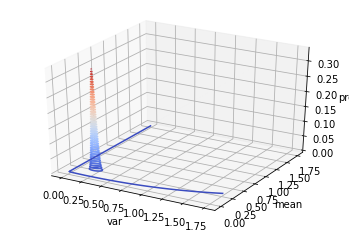

In [7]:
#fit model

#use offset and take log of data
context = get_context("walmart_map.yaml")
length = context.loc[context["edge_id"] == edge]["edge_length"]
offset= np.min([float(length / (0.55 * 1.1) ), np.min(t_op) - 0.01])
t_log = np.log(t_op - offset)

#n_terms = 1 if you want just the initial estimates
n_terms = len(t_log)    
t_obs = t_log[0:n_terms//2]

#set parameters
mu_0 = 1
beta = 0.1
a = 1
b = 1

#Bayesian MAP estimate of mean & variance of Gaussian distribution
tic = time.time()
mean_test, var_test, posterior, mean_map, var_map = Normal_Gamma_bayes(t_obs, mu_0, beta, a, b)
toc = time.time()
print("MAP mean:", mean_map, "    MAP var:", var_map)
print("Time for calculation:", toc-tic, "secs")

Text(0.5, 1.0, 'WayPoint68_WayPoint61')

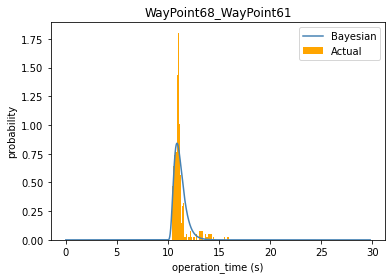

In [8]:
#Plot against actual data

precision = 2
t_start= 10**(-precision)
t_stop = ( (np.max(t_op)) //5)*5 + 5    #round up to nearest 5 secs
t_step = 10**(-precision)
t_test = np.arange(t_start,t_stop,t_step)

#Duration distribution using MAP parameters from Bayesian method
p_bayes = Lognormal(t_test,mean_map,var_map)

#account for offset
t_offset = np.arange(t_stop, t_stop+offset, t_step)
p_offset = np.zeros(len(t_offset))
p_bayes = np.array([*p_offset, *p_bayes])
t_test = np.array([*t_test, *t_offset])

#plot
plt.plot(t_test,p_bayes, color = "steelblue", alpha = 1)
plt.hist(t_op, density = True, bins = 50, color = "orange")

plt.legend(["Bayesian", "Actual"])
plt.xlabel("operation_time (s)")
plt.ylabel("probability")
plt.title(edge)

# 3) Measures of Error

## 3a) Continuous Ranked Probability Score (CRPS)
- F(y) is the predicted CDF, x is the observation
- CRPS(F,x) = INT(-inf,x) {F(y)^2} dy + INT(x,inf) {(F(y) - 1)^2} dy

(0.0, 29.78000000000153)

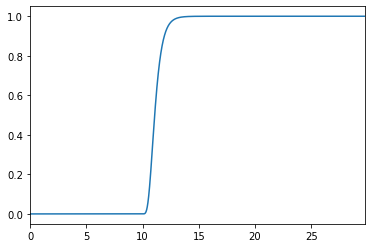

In [9]:
#calculate cdf
cdf_bayes = integrate_pdf(p_bayes, t_step)
plt.plot(t_test,cdf_bayes, alpha = 1)
plt.xlim([0,t_test[-1]])

min_crps: 0.11920662517061001
t_new: 11.07


Text(0, 0.5, 'CPRS')

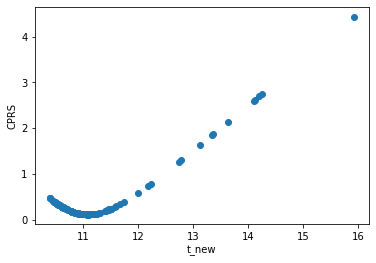

In [10]:
#Calculate CRPS score for a vector of observations
t_new = np.array(t_op[n_terms//2:])
#t_new = 10
crps = error_crps(t_new, cdf_bayes, t_test)
print("min_crps:", np.min(crps["crps"]) )
print("t_new:", crps["t_new"][np.argmin(crps["crps"])] )
plt.scatter(crps["t_new"],crps["crps"])
plt.xlabel("t_new")
plt.ylabel("CPRS")

In [11]:
#Calculate CRPS score for a single observations
t_new = 10
crps_single = error_crps_single(t_new, cdf_bayes, t_test)
print(crps_single)

0.8687693303350246


## 3b) Test my implementation of CRPS 

In [9]:
x_new = 0
precision = 5

#compare to library functions
import properscoring as ps
tic1 = time.time()
library_stat = ps.crps_gaussian(x_new, mu=0, sig=1)
toc1 = time.time()

#my own implementation
x = np.arange(-10,10,0.1**precision)
x = np.round(x,precision)
cdf_test = sp.stats.norm.cdf(x, loc=0, scale=1)
tic2 = time.time()
my_stat = error_crps_single(x_new, cdf_test, x, method = "rectangle")
toc2 = time.time()

print("Library:", library_stat, "    Time:", toc1-tic1)
print("Mine:", my_stat, "    Time:", toc2-tic2)

Library: 0.23369497725510913     Time: 0.0
Mine: 0.23369497725291088     Time: 0.020943164825439453


## 3c) ~~Posterior Predictive Accuracy~~
- Accuracy = p(t_new|t) = INT{ p(t_new|params) * p(params|t) } wrt params
- Accuracy = E{ p(t_new|params) }
You can sample this expectation
- Draw params_i from posterior distribution (MCMC)
- Compute p(y_new|params_i)
- Repeat and take average


# 4) Clustering edges

## 4a) Distance matrices
- KS statistic
- Edge length difference
- end node difference

In [13]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(df)


Time taken: 110.33537983894348 secs


In [14]:
#Create matrix of edge_length distances
context = get_context()
length_matrix, length_edges = distances_length(context)


Time taken: 0.8809092044830322 secs
Time taken:  1.9440228939056396 secs


In [15]:
#Create matrix of connections_diff distances
context = get_context()
connections_matrix, connections_edges = distances_connections(context)

Time taken: 0.8606960773468018 secs
Time taken:  3.558614730834961 secs


In [16]:
#convert to df & save to excel
ks_dict = {}
for i in range(len(ks_edges)):
    ks_dict[ks_edges[i]] = ks_matrix[i]
ks_df = pd.DataFrame(ks_dict, columns = ks_edges, index = ks_edges)
ks_df.to_excel("distances_ks.xlsx")

length_dict = {}
for i in range(len(length_edges)):
    length_dict[length_edges[i]] = length_matrix[i]
length_df = pd.DataFrame(length_dict, columns = length_edges, index = length_edges)
length_df.to_excel("distances_length.xlsx")

connections_dict = {}
for i in range(len(connections_edges)):
    connections_dict[connections_edges[i]] = connections_matrix[i]
connections_df = pd.DataFrame(connections_dict, columns = connections_edges, index = connections_edges)
connections_df.to_excel("distances_connections.xlsx")
print("done")

done


In [48]:
#read from excel
ks_df = pd.read_excel("distances_ks.xlsx", columns = ks_edges)
ks_test = ks_df.to_numpy()
ks_mat = []
for i in range(len(ks_test)):
    ks_mat.append(ks_test[i][1:])

#ks_matrix = ks_mat


## 4b) Clustering
- Try hierarchical agglomerative clustering
- Silhouette score is between [-1, 1]. Higher scores are densely clustered and well-separated


### KS distance

6 0.6872476457567968


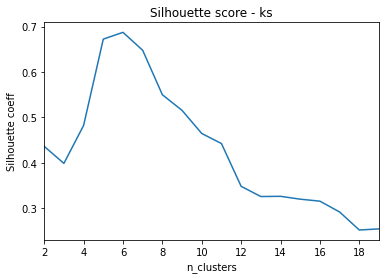

In [39]:
#for ks statistic
max_clusters = 20
n_clusters = np.arange(2,max_clusters,1)
s_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    s = silhouette_score(ks_matrix , labels, metric='euclidean')
    s_list.append(s)

plt.plot(n_clusters,s_list)
plt.title("Silhouette score - ks")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette coeff")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(s_list)], np.max(s_list))

8 550.93704799205


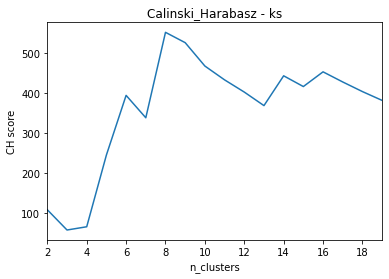

In [35]:
#for ks statistic - Calinski-Harabasz Index
max_clusters = 20
n_clusters = np.arange(2,max_clusters,1)
ch_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    ch = sklearn.metrics.calinski_harabasz_score(ks_matrix , labels)
    ch_list.append(ch)

plt.plot(n_clusters,ch_list)
plt.title("Calinski_Harabasz - ks")
plt.xlabel("n_clusters")
plt.ylabel("CH score")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(ch_list)], np.max(ch_list))

6 0.29759872576080953


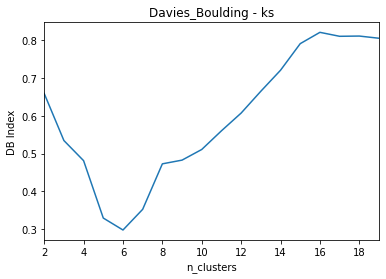

In [38]:
#for ks statistic - Davies-Bouldin Index
max_clusters = 20
n_clusters = np.arange(2,max_clusters,1)
db_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    db = sklearn.metrics.davies_bouldin_score(ks_matrix , labels)
    db_list.append(db)

plt.plot(n_clusters,db_list)
plt.title("Davies_Boulding - ks")
plt.xlabel("n_clusters")
plt.ylabel("DB Index")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmin(db_list)], np.min(db_list))

In [40]:
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[5 0 0 5 0 5 0 3 0 0 5 5 0 5 0 0 0 0 5 0 0 5 0 0 5 0 0 5 0 0 3 0 5 5 0 3 0
 0 0 0 4 3 3 4 3 0 0 0 3 0 3 0 2 2 1 2 2 0 0 2 1 4 1 1 1 1 4 3 1 1 1 1 1 1
 1 4 1 0 4 1 1 1 1 1 1 1 1 1 4 1 1 4 3 1 1 1 0 1 1 1 4 4 3 1 4 1 4 1 0 1 0
 4 1 4 4 1 1 4 1 1 1 1 4 1 1 4 1 1 4 1 1 1 1 1 1 1 4 3 1 1 4 1 1 1 1 4 1 1
 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 4 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
6 clusters


### Length difference

5 0.9705289087667147


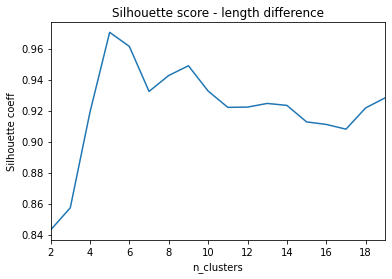

In [19]:
#for edge length difference
max_clusters = 20
n_clusters = np.arange(2,max_clusters,1)
s_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( length_matrix )
    s = silhouette_score(length_matrix , labels, metric='euclidean')
    s_list.append(s)

plt.plot(n_clusters,s_list)
plt.title("Silhouette score - length difference")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette coeff")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(s_list)], np.max(s_list))

In [20]:
#for edge_length difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( length_matrix )
print(labels)
length_clusters = pd.DataFrame(index = np.arange(len(length_edges)),columns = ["edge_id", "cluster_id"])
length_clusters["edge_id"] = length_edges
length_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[3 1 3 3 3 3 0 3 2 0 2 2 3 3 3 3 3 3 3 3 3 0 3 2 0 3 3 0 0 0 0 0 1 3 1 3 1
 1 3 3 3 3 3 3 3 3 1 1 3 1 3 1 3 3 3 3 3 3 3 3 3 3 1 0 3 0 1 1 3 1 3 3 3 3
 3 3 3 3 3 3 3 0 1 0 1 1 3 1 3 3 3 3 3 3 3 3 3 0 0 1 1 3 3 1 3 1 3 3 3 3 3
 3 3 3 3 0 1 0 1 1 3 4 3 3 3 3 3 3 3 3 3 3 0 3 1 0 4 4 3 1 3 3 3 3 3 3 3 3
 3 0 3 1 0 4 1 1 3 4 3 3 3 3 3 3 3 3 3 0 0 1 4 3 4 0 1 3 3 1 3 1 3 3 3 3 3
 3 0 3 4 0 1 1 4 0 3 3 3 3 3 3 3 3 3 3 3 0 3 1 0 4 4 0 3 2 3 3 3 3 3 3 3 3
 3 0 0 4 2 3 2 0 2 3 3 3 3 3 3 3 3 3 3 0 3 2 0 2 2 0 3 2 3 3 3 3 3 3]
5 clusters


### Connections difference

11 0.9921875


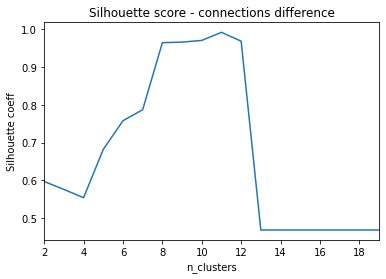

In [21]:
#for connections difference
max_clusters = 20
n_clusters = np.arange(2,max_clusters,1)
s_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( connections_matrix )
    s = silhouette_score(connections_matrix , labels, metric='euclidean')
    s_list.append(s)

plt.plot(n_clusters,s_list)
plt.title("Silhouette score - connections difference")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette coeff")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(s_list)], np.max(s_list))

In [26]:
print(s_list[7])

0.9662678378433582


In [22]:
#for connections difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( connections_matrix )
print(labels)
connections_clusters = pd.DataFrame(index = np.arange(len(connections_edges)),columns = ["edge_id", "cluster_id"])
connections_clusters["edge_id"] = connections_edges
connections_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[ 1  3  1  1  1  1  3  1  4  6  6  7  1  1  1  1  1  1  1  1  1  1  1  3
  1  1  3 10 10 10 10 10  6  6  4  6  4  4  1  3  1  1  1  1  3  1  4  4
  6  4  6  4  1  1  3  1  1  1  1  1  1  3  4  6  6  3  3  4  6  4  3  1
  1  1  1  1  1  1  1  1  1  3  6  6  4  4  6  4  3  1  1  1  1  1  1  1
  1  3  6  4  4  1  1  4  6  4  3  1  1  1  1  1  1  1  1  3  4  6  4  4
  6  4  3  1  1  1  1  1  1  1  1  1  3  1  4  6  4  4  6  4  3  1  1  1
  1  1  1  1  1  3  1  3  6  4  4  4  6  9  3  1  1  1  1  1  1  1  1  3
  6  4  4  0  8  2  5  1  7  6  6  4  1  1  1  1  1  1  3  1  4  6  4  5
  5  2  0  1  7  1  1  1  1  1  1  3  1  3  1  4  6  4  5  2  0  5  7  1
  1  1  1  1  1  1  1  3  6  4  4  0  5  2  5  1  1  1  7  1  1  1  1  1
  1  3  1  4  6  4  5  2  0  0  1  7  1  1  1  1]
11 clusters


## 4c) Draw Graphs

no. of edges: 256
no. of colors: 256


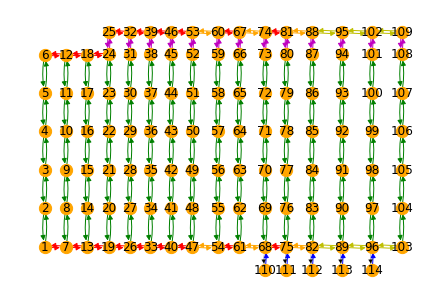

In [23]:
G = draw_clusters("walmart_map.yaml", ks_clusters)
plt.savefig("clusters_ks.svg")

no. of edges: 256
no. of colors: 256


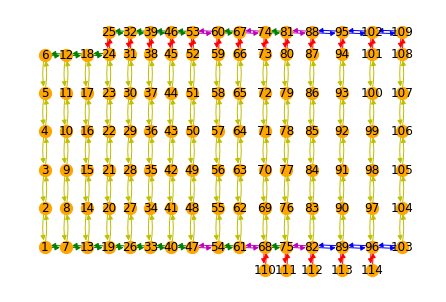

In [24]:
G = draw_clusters("walmart_map.yaml", length_clusters)
plt.savefig("clusters_length.svg")

no. of edges: 256
no. of colors: 256


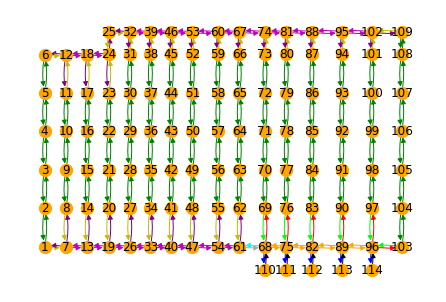

In [25]:
G = draw_clusters("walmart_map.yaml", connections_clusters)
plt.savefig("clusters_connections.svg")

# 5) Test anomalies

## 5a) Do the histograms actually look similar?
- for edges in the same cluster

366 349


Text(0.5, 0, 'Duration (s)')

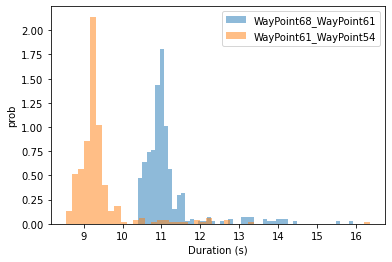

In [9]:
# Select data of interest
wp1 = "WayPoint68"
wp2 = "WayPoint61"
edge1 = wp1 + "_" + wp2
subset1 = select_data_edge(df, edge1)
#independent variable to plot over
t_op1 = subset1["operation_time"]

# Select data of interest
wp1 = "WayPoint61"
wp2 = "WayPoint54"
edge2 = wp1 + "_" + wp2
subset2 = select_data_edge(df, edge2)
#independent variable to plot over
t_op2 = subset2["operation_time"]
print(len(t_op1), len(t_op2))

plt.hist(t_op1, density = True, bins = 50, alpha = 0.5);
plt.hist(t_op2, density = True, bins = 50, alpha = 0.5);
plt.legend([edge1, edge2])
plt.ylabel("prob")
plt.xlabel("Duration (s)")


In [4]:
count = df["edge_id"].value_counts()
count.to_csv('waypoint_pairs_random.csv')          #save and reload for DataFrame format
count = pd.read_csv("waypoint_pairs_random.csv")
count.columns = ["edge_id", "samples"]      #rename columns
count.head()

,edge_id,samples
0,WayPoint68_WayPoint61,366
1,WayPoint61_WayPoint54,349
2,WayPoint75_WayPoint68,320
3,WayPoint54_WayPoint47,303
4,WayPoint47_WayPoint40,268


no. of edges: 256
Legend:
Red < 20 samples
Orange < 50 samples
Green < 100 samples
Blue < 250 samples
Purple > 250 samples


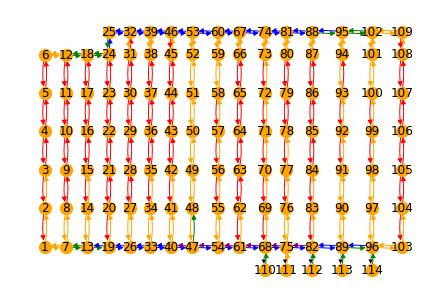

In [5]:
G = draw_count("walmart_map.yaml", count)

# 6) Blenheim map
- What is the effect of increasing congestion?

## 6a) Filter Data

In [30]:
#1) Import data from PyMongo
df_blenheim = get_data("blenheim_targeted")
#2) Preliminary filtering
df_blenheim  = filter_data1(df_blenheim)
df_blenheim.head()

,origin,target,edge_id,is_final,operation_time,start,finish,run_id,agent
0,WayPoint7,WayPoint10,WayPoint7_WayPoint10,False,10.748,2021-02-23 20:02:31.477,2021-02-23 20:02:42.255,9df2d216-e39d-45a0-8317-7c37459270df,/robot_1/rapport_navigation
1,WayPoint9,WayPoint12,WayPoint9_WayPoint12,False,10.778,2021-02-23 20:02:31.987,2021-02-23 20:02:42.765,9df2d216-e39d-45a0-8317-7c37459270df,/robot_3/rapport_navigation
2,WayPoint8,WayPoint11,WayPoint8_WayPoint11,False,11.038,2021-02-23 20:02:33.577,2021-02-23 20:02:44.355,9df2d216-e39d-45a0-8317-7c37459270df,/robot_4/rapport_navigation
3,WayPoint6,WayPoint9,WayPoint6_WayPoint9,False,11.903,2021-02-23 20:02:34.511,2021-02-23 20:02:45.289,9df2d216-e39d-45a0-8317-7c37459270df,/robot_2/rapport_navigation
4,WayPoint4,WayPoint7,WayPoint4_WayPoint7,False,12.243,2021-02-23 20:02:35.555,2021-02-23 20:02:46.333,9df2d216-e39d-45a0-8317-7c37459270df,/robot_0/rapport_navigation


In [32]:
#3a) Count n_robots
adjacent = get_adjacent("blenheim_map.yaml")
df_blenheim = filter_data4(df_blenheim, adjacent)
df_blenheim.head()

Time taken: 0.06781768798828125 secs
0 iterations 0.0009970664978027344 secs
1000 iterations 119.9464738368988 secs
2000 iterations 235.1204376220703 secs
3000 iterations 348.04640078544617 secs
4000 iterations 456.4602749347687 secs
5000 iterations 562.2349157333374 secs
6000 iterations 662.3782110214233 secs
7000 iterations 759.4603202342987 secs
8000 iterations 852.4239363670349 secs
9000 iterations 942.3605854511261 secs
10000 iterations 1030.3485834598541 secs
11000 iterations 1113.655609369278 secs
12000 iterations 1193.350301027298 secs
13000 iterations 1268.7675831317902 secs
14000 iterations 1340.7819266319275 secs
Time taken 1398.0941271781921 secs


,origin,target,edge_id,is_final,operation_time,start,finish,run_id,agent,n_robots
0,WayPoint7,WayPoint10,WayPoint7_WayPoint10,False,10.748,2021-02-23 20:02:31.477,2021-02-23 20:02:42.255,9df2d216-e39d-45a0-8317-7c37459270df,/robot_1/rapport_navigation,2
1,WayPoint9,WayPoint12,WayPoint9_WayPoint12,False,10.778,2021-02-23 20:02:31.987,2021-02-23 20:02:42.765,9df2d216-e39d-45a0-8317-7c37459270df,/robot_3/rapport_navigation,2
2,WayPoint8,WayPoint11,WayPoint8_WayPoint11,False,11.038,2021-02-23 20:02:33.577,2021-02-23 20:02:44.355,9df2d216-e39d-45a0-8317-7c37459270df,/robot_4/rapport_navigation,1
3,WayPoint6,WayPoint9,WayPoint6_WayPoint9,False,11.903,2021-02-23 20:02:34.511,2021-02-23 20:02:45.289,9df2d216-e39d-45a0-8317-7c37459270df,/robot_2/rapport_navigation,1
4,WayPoint4,WayPoint7,WayPoint4_WayPoint7,False,12.243,2021-02-23 20:02:35.555,2021-02-23 20:02:46.333,9df2d216-e39d-45a0-8317-7c37459270df,/robot_0/rapport_navigation,1


In [33]:
#3b) save to excel
df_blenheim.to_excel("n_robots_blenheim_targeted.xlsx")
print("done")

done


In [34]:
#3c) load from excel
df_blenheim = pd.read_excel("n_robots_blenheim_targeted.xlsx")
print("done")

done


In [35]:
#4) Get rid of is_final = True & n_robots != 1
#create is_initial column and get rid of is_initial == True
df_blenheim = filter_data3(df_blenheim, remove_multimodal = False)
df_blenheim.head()

,origin,target,edge_id,operation_time,start,finish,n_robots,is_final,is_initial
0,WayPoint4,WayPoint7,WayPoint4_WayPoint7,11.574,2021-02-24 13:25:40.322,2021-02-24 13:25:51.100,1,False,False
1,WayPoint7,WayPoint10,WayPoint7_WayPoint10,12.874,2021-02-24 13:26:11.520,2021-02-24 13:26:22.298,1,False,False
2,WayPoint10,WayPoint3,WayPoint10_WayPoint3,13.195,2021-02-24 13:26:42.290,2021-02-24 13:26:53.068,2,False,False
3,WayPoint3,WayPoint1,WayPoint3_WayPoint1,16.896,2021-02-24 13:27:22.148,2021-02-24 13:27:32.926,4,False,False
6,WayPoint1,WayPoint3,WayPoint1_WayPoint3,12.965,2021-02-24 13:29:07.287,2021-02-24 13:29:18.065,2,False,False


In [44]:
len(df_blenheim[ df_blenheim["n_robots"] == 1 ])

5668

In [45]:
#5a) save to excel
df_blenheim.to_excel("filtered_data_blenheim_targeted.xlsx")
print("done")

done


In [46]:
#5b) load from excel
df_blenheim = pd.read_excel("filtered_data_blenheim_targeted.xlsx")
print("done")

done


## 6b) Clustering

In [47]:
#separate by congestion level
congestion_1 = df_blenheim[ df_blenheim["n_robots"] == 1 ]
congestion_2 = df_blenheim[ df_blenheim["n_robots"] == 2 ]
congestion_3 = df_blenheim[ df_blenheim["n_robots"] == 3 ]
congestion_4 = df_blenheim[ df_blenheim["n_robots"] == 4 ]
print(len(congestion_1),len(congestion_2),len(congestion_3),len(congestion_4))

5668 3391 557 23


### n_robots = 1

In [60]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_1)

Time taken: 1.2910511493682861 secs


2 0.5822425362868678


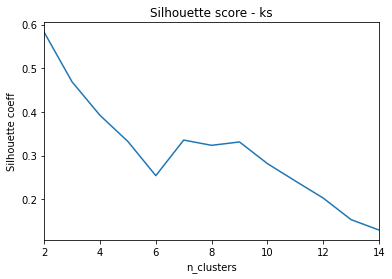

In [61]:
#for ks statistic
max_clusters = 15
n_clusters = np.arange(2,max_clusters,1)
s_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    s = silhouette_score(ks_matrix , labels, metric='euclidean')
    s_list.append(s)

plt.plot(n_clusters,s_list)
plt.title("Silhouette score - ks")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette coeff")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(s_list)], np.max(s_list))



14 0.2441159979922998


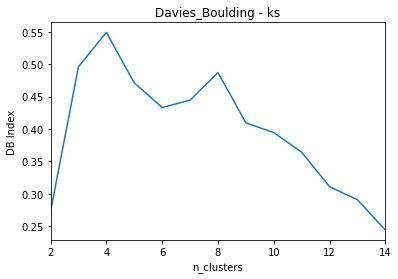

In [62]:
#for ks statistic - Davies-Bouldin Index
max_clusters = 15
n_clusters = np.arange(2,max_clusters,1)
db_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    db = sklearn.metrics.davies_bouldin_score(ks_matrix , labels)
    db_list.append(db)

plt.plot(n_clusters,db_list)
plt.title("Davies_Boulding - ks")
plt.xlabel("n_clusters")
plt.ylabel("DB Index")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmin(db_list)], np.min(db_list))

In [63]:
clustering = AgglomerativeClustering(n_clusters=n_clusters[np.argmax(s_list)], affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
2 clusters


no. of edges: 22
no. of colors: 22


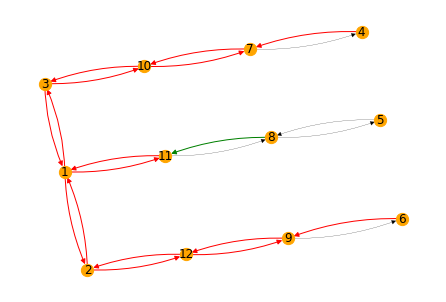

In [64]:
G = draw_clusters("blenheim_map.yaml", ks_clusters)
plt.savefig("clusters_ks_blenheim1.svg")

### n_robots = 2

In [65]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_2)

Time taken: 0.8309576511383057 secs


2 0.5073016422141123


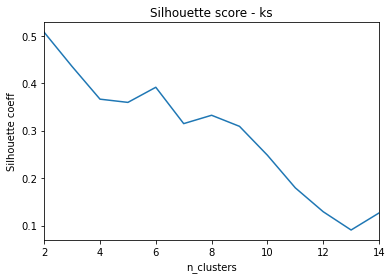

In [66]:
#for ks statistic
max_clusters = 15
n_clusters = np.arange(2,max_clusters,1)
s_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    s = silhouette_score(ks_matrix , labels, metric='euclidean')
    s_list.append(s)

plt.plot(n_clusters,s_list)
plt.title("Silhouette score - ks")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette coeff")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(s_list)], np.max(s_list))



14 0.15075401725939924


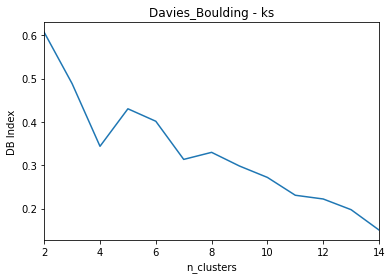

In [67]:
#for ks statistic - Davies-Bouldin Index
max_clusters = 15
n_clusters = np.arange(2,max_clusters,1)
db_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    db = sklearn.metrics.davies_bouldin_score(ks_matrix , labels)
    db_list.append(db)

plt.plot(n_clusters,db_list)
plt.title("Davies_Boulding - ks")
plt.xlabel("n_clusters")
plt.ylabel("DB Index")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmin(db_list)], np.min(db_list))

In [90]:
clustering = AgglomerativeClustering(n_clusters=4, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[2 2 2 2 2 2 2 0 2 2 0 3 1]
4 clusters


no. of edges: 22
no. of colors: 22


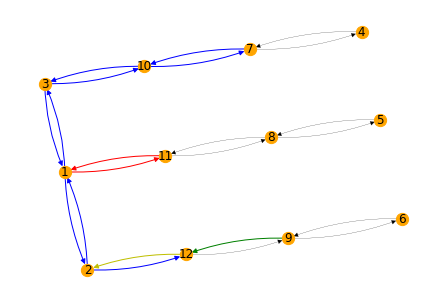

In [91]:
G = draw_clusters("blenheim_map.yaml", ks_clusters)
plt.savefig("clusters_ks_blenheim2.svg")

### n_robots = 3

In [113]:
#create matrix of ks distances
ks_matrix, ks_edges = distances_ks(congestion_3)

Time taken: 0.6720924377441406 secs


In [115]:
ks_edges

['WayPoint1_WayPoint3',
 'WayPoint3_WayPoint1',
 'WayPoint10_WayPoint3',
 'WayPoint3_WayPoint10',
 'WayPoint2_WayPoint1',
 'WayPoint1_WayPoint2',
 'WayPoint7_WayPoint10',
 'WayPoint1_WayPoint11',
 'WayPoint10_WayPoint7',
 'WayPoint2_WayPoint12',
 'WayPoint11_WayPoint1',
 'WayPoint12_WayPoint2',
 'WayPoint9_WayPoint12']

4 0.5000814771395785


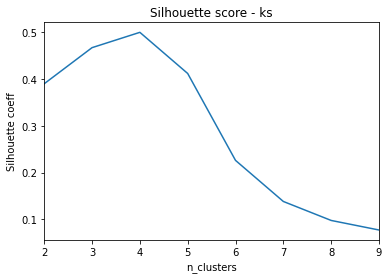

In [77]:
#for ks statistic
max_clusters = 10
n_clusters = np.arange(2,max_clusters,1)
s_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    s = silhouette_score(ks_matrix , labels, metric='euclidean')
    s_list.append(s)

plt.plot(n_clusters,s_list)
plt.title("Silhouette score - ks")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette coeff")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(s_list)], np.max(s_list))



5 0.24212184483173838


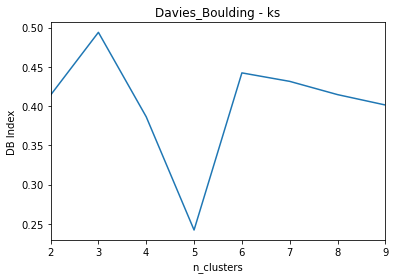

In [79]:
#for ks statistic - Davies-Bouldin Index
max_clusters = 10
n_clusters = np.arange(2,max_clusters,1)
db_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( ks_matrix )
    db = sklearn.metrics.davies_bouldin_score(ks_matrix , labels)
    db_list.append(db)

plt.plot(n_clusters,db_list)
plt.title("Davies_Boulding - ks")
plt.xlabel("n_clusters")
plt.ylabel("DB Index")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmin(db_list)], np.min(db_list))

In [94]:
clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( ks_matrix )
print(labels)
ks_clusters = pd.DataFrame(index = np.arange(len(ks_edges)),columns = ["edge_id", "cluster_id"])
ks_clusters["edge_id"] = ks_edges
ks_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[0 0 0 0 0 0 0 4 0 0 2 3 1]
4 clusters


no. of edges: 22
no. of colors: 22


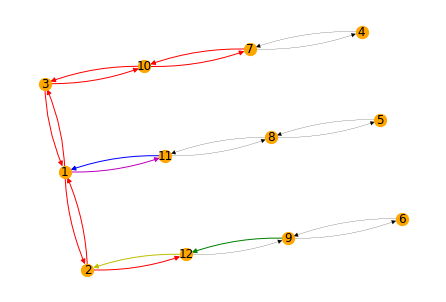

In [95]:
G = draw_clusters("blenheim_map.yaml", ks_clusters)
plt.savefig("clusters_ks_blenheim3.svg")

### Cluster by spatial features

In [98]:
#Create matrix of edge_length distances
context = get_context("blenheim_map.yaml")
length_matrix, length_edges = distances_length(context)

#Create matrix of connections_diff distances
context = get_context("blenheim_map.yaml")
connections_matrix, connections_edges = distances_connections(context)



Time taken: 0.09782218933105469 secs
Time taken:  0.016954898834228516 secs
Time taken: 0.08078312873840332 secs
Time taken:  0.027292728424072266 secs


11 0.9999999437551995


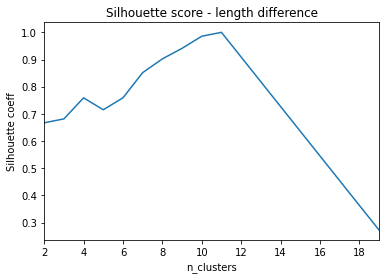

In [99]:
#for edge length difference
max_clusters = 20
n_clusters = np.arange(2,max_clusters,1)
s_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( length_matrix )
    s = silhouette_score(length_matrix , labels, metric='euclidean')
    s_list.append(s)

plt.plot(n_clusters,s_list)
plt.title("Silhouette score - length difference")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette coeff")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(s_list)], np.max(s_list))

In [108]:
#for edge_length difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=11, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( length_matrix )
print(labels)
length_clusters = pd.DataFrame(index = np.arange(len(length_edges)),columns = ["edge_id", "cluster_id"])
length_clusters["edge_id"] = length_edges
length_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[ 8  7  9 10  5  3  9  6  4  7  6  5  8  2  1  0  2 10  1  3  4  0]
11 clusters


no. of edges: 22
no. of colors: 22


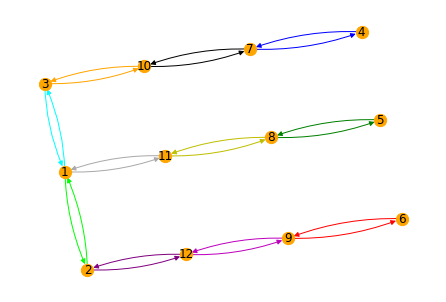

In [109]:
G = draw_clusters("blenheim_map.yaml", length_clusters)
plt.savefig("clusters_length_blenheim.svg")

5 1.0


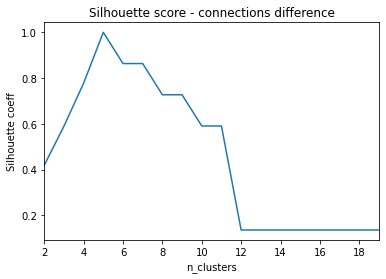

In [110]:
#for connections difference
max_clusters = 20
n_clusters = np.arange(2,max_clusters,1)
s_list = []
for i in n_clusters:
    clustering = AgglomerativeClustering(n_clusters=i, affinity='precomputed', linkage = 'average')
    labels = clustering.fit_predict( connections_matrix )
    s = silhouette_score(connections_matrix , labels, metric='euclidean')
    s_list.append(s)

plt.plot(n_clusters,s_list)
plt.title("Silhouette score - connections difference")
plt.xlabel("n_clusters")
plt.ylabel("Silhouette coeff")
plt.xlim([n_clusters[0], n_clusters[-1]]);
print(n_clusters[np.argmax(s_list)], np.max(s_list))

In [111]:
#for connections difference
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage = 'average')
labels = clustering.fit_predict( connections_matrix )
print(labels)
connections_clusters = pd.DataFrame(index = np.arange(len(connections_edges)),columns = ["edge_id", "cluster_id"])
connections_clusters["edge_id"] = connections_edges
connections_clusters["cluster_id"] = labels
print(n_clusters[np.argmax(s_list)], "clusters")

[4 4 4 3 3 3 1 3 3 1 3 3 1 2 2 2 0 3 0 3 3 0]
5 clusters


no. of edges: 22
no. of colors: 22


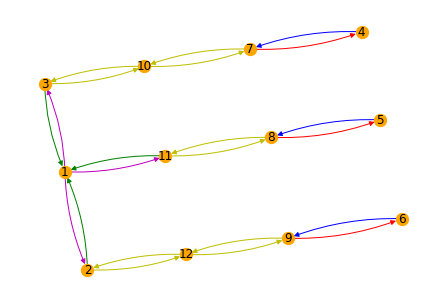

In [112]:
G = draw_clusters("blenheim_map.yaml", connections_clusters)
plt.savefig("clusters_connections_blenheim.svg")